<p align="center">
  <img src="https://logodownload.org/wp-content/uploads/2018/04/ufrn-logo.png" width="200" />
</p>

### <center> **Introdução à Processamento de Linguagem Natural (NLP) - Detecção de Fake News.** </center>

**Discentes:** DIEGO MAIA MARQUES e VINÍCIUS VENCESLAU VENANCIO DA PENHA

**Docente:** JOSÉ ALFREDO FERREIRA COSTA

**Disciplina:** **ELE0606** - Tópicos Especiais em Inteligência Artificial

##**Referências:**

[1] **O que é NLP (Processamento de Linguagem Natural), seus usos e como utilizar**. Disponível em: https://rockcontent.com/br/blog/o-que-e-nlp/. Acesso em: 14 de dezembro de 2023.


[2] SHU, K. **KaiDMML/FakeNewsNet**. Disponível em: <https://github.com/KaiDMML/FakeNewsNet>. Acesso em: 19 de dezembro de 2023.


[3] **Introdução ao NLTK na prática**. Disponível em: <https://www.youtube.com/watch?v=siVUal-TeMc>. Acesso em: 19 de dezembro de 2023.


[4] OPENAI. **ChatGPT**. 2023. Disponível em: https://openai.com/. Acesso em: 19 de dezembro de 2023.

---

####**Requisitos da atividade:**

1.   Utilizar corpus com textos de notícias rotuladas (falsas e verdadeiras)
2.   Comparar resultado com regressão logística e MLP na classificação

➡️ Tendo em vista que nenhuma das bases de dados fornecidas pelo docente possui uma distinção explícita entre notícias verdadeiras e falsas, foi necessário buscar uma base de dados que detém estes requisitos.

Nesse viés, foi utilizado a base de dados proveniente da **FakeNewsNet**, onde:

*  **politifact_fake.csv** - Amostras relacionadas a notícias falsas coletadas pelo PolitiFact
*   **politifact_real.csv** - Amostras relacionadas a notícias reais coletadas pelo PolitiFact



Cada um dos arquivos CSV mencionados é um arquivo separado por vírgulas e possui as seguintes colunas:

* **id** - Identificador único para cada notícia
* **url** - URL do artigo da web que publicou essa notícia
* **title** - Título do artigo de notícia
* **tweet_ids** - IDs de tweets que compartilham a notícia. Este campo é uma lista de IDs de tweets separados por tabulação.
* **label** - Rotulação da notícia em **verdadeira** ou **falsa** (**0** ou **1**)

### **1. Preparação do Ambiente e Dados:**

In [1]:
import pandas as pd

# Carregar os dados
fake_news = pd.read_csv('politifact_fake.csv')
real_news = pd.read_csv('politifact_real.csv')

# Adicionar rótulos aos dados
fake_news['label'] = 1  # Notícias falsas têm rótulo 1
real_news['label'] = 0  # Notícias verdadeiras têm rótulo 0

# Combinar os dados em um único DataFrame
data = pd.concat([fake_news, real_news], ignore_index=True)

# Embaralhar os dados
data = data.sample(frac=1).reset_index(drop=True)

# Visualizar as primeiras linhas dos dados
data.head()

,id,news_url,title,tweet_ids,label
0,politifact12751,https://www.census.gov/foreign-trade/statistic...,US Trade in Goods,998217739683680256\t998220389787553792\t998234...,0
1,politifact14305,http://politicot.com/paul-ryan-22-million-amer...,Paul Ryan: “22 Million Americans Choose To Be ...,NaN,1
2,politifact14306,https://web.archive.org/web/20170806200608/htt...,Obama Goes To G20 Summit,1436642283\t1436642464\t1436643954\t1437071990...,1
3,politifact4372,http://www.pbs.org/wnet/need-to-know/economy/t...,"This Labor Day, we need protests",NaN,0
4,politifact15224,https://www.viraltruthwire.com/obama-secretly-...,Obama Secretly Flees US – Leaves Stunning Evid...,977934019273699328\t978722696711335942\t979262...,1


In [2]:
# Verificar informações sobre os dados
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1056 non-null   object
 1   news_url   995 non-null    object
 2   title      1056 non-null   object
 3   tweet_ids  801 non-null    object
 4   label      1056 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


In [3]:
import nltk
from nltk.corpus import stopwords # Importa a lista de stopwords da biblioteca NLTK
from nltk.tokenize import word_tokenize # Importa a função word_tokenize do NLTK
import string

nltk.download('stopwords')
nltk.download('punkt') # Um modelo para dividir um texto em tokens (como palavras ou frases)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Função para pré-processar o texto
def preprocess_text(text):
    # Tokenização
    tokens = word_tokenize(text.lower())  # Converte para minúsculas e tokeniza

    # Remoção de stopwords e pontuações
    stop_words = set(stopwords.words('english')) # Usa-se 'english', uma vez que a base de dados é americana
    tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]

    # Reconstruir o texto após o pré-processamento
    processed_text = ' '.join(tokens)
    return processed_text

# Aplicar pré-processamento ao DataFrame
data['processed_text'] = data['title'].apply(preprocess_text)

# Visualizar os primeiros textos processados
data['processed_text'].head()

0                                       us trade goods
1    paul ryan “ 22 million americans choose poor ’...
2                                obama goes g20 summit
3                              labor day need protests
4    obama secretly flees us – leaves stunning evid...
Name: processed_text, dtype: object

In [5]:
# Exibir uma amostra dos dados
sample_data = data.sample(n=10, random_state=42)  # Mostrar 10 entradas aleatórias
print(sample_data[['processed_text', 'label']])

                                         processed_text  label
260   kasich “ woman intelligent enough keep legs cl...      1
832        fed fight save america washington rick perry      0
846                             poverty 2005 highlights      0
1007  nra president jim porter falsely accused sayin...      1
88             video special preview jersey shore miami      0
457   busted obama holding secret meetings overtake ...      1
184   ohio student suspended staying class national ...      1
988   un refugee agency welcomes arrival 10,000th sy...      0
367   trump ’ top scientist pick “ scientists dumb r...      1
558                       breaking laura ingraham fired      1


### **2. Separação dos Dados em Treinamento e Teste:**

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Separar os dados em treino e teste
X = data['processed_text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vetorização dos textos usando TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### **3. Criação do Modelo de Classificação (MLP) e Visualização dos Resultados:**

In [7]:
import warnings
from sklearn.exceptions import ConvergenceWarning # Para remover a mensagem de aviso de não convergência

# Desativar os warnings de convergência temporariamente
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Criar e treinar o modelo MLP
mlp = MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=100, random_state=42)
mlp.fit(X_train_tfidf, y_train)

# Fazer previsões
predictions1 = mlp.predict(X_test_tfidf)

# Avaliar o modelo
accuracy = accuracy_score(y_test, predictions1)
print(f'Acurácia do modelo: {accuracy:.2f}\n')

print('Relatório de Classificação:')
print(classification_report(y_test, predictions1))

Acurácia do modelo: 0.82

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       124
           1       0.79      0.77      0.78        88

    accuracy                           0.82       212
   macro avg       0.82      0.81      0.81       212
weighted avg       0.82      0.82      0.82       212



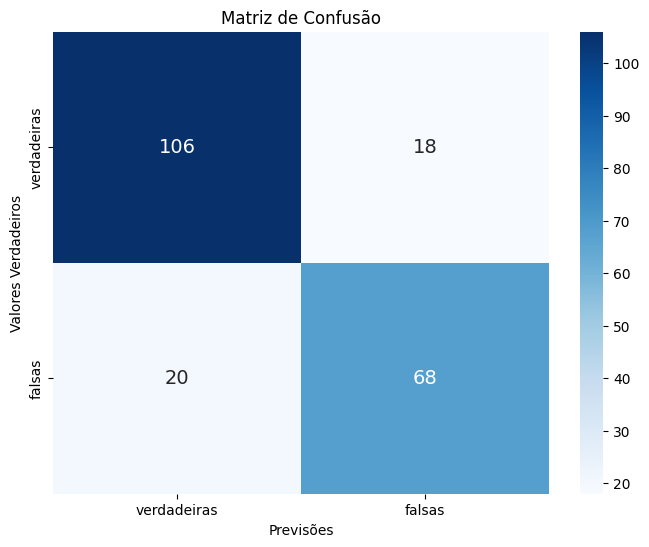

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Criação e visualização da matriz confusão
rotulos = ['verdadeiras', 'falsas']
cm1 = confusion_matrix(y_test, predictions1)

plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14}, xticklabels=rotulos, yticklabels=rotulos)
plt.xlabel('Previsões')
plt.ylabel('Valores Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()

### **4. Criação do Modelo de Classificação (Regressão Logística) e Visualização dos Resultados:**

In [9]:
from sklearn.linear_model import LogisticRegression

# Criar o classificador de Regressão Logística -> "max_iter=10000" representa o número de iterações na tentativa de encontrar uma solução aceitável.
clf = LogisticRegression(max_iter=10000)

# Treinar o modelo.
clf.fit(X_train_tfidf, y_train)

# Fazer previsões no conjunto de teste.
predictions2 = clf.predict(X_test_tfidf)

# Calcular e exibir a acurácia.
accuracy = accuracy_score(y_test, predictions2)
print(f'Acurácia da regressão logística: {accuracy:.2f}')

Acurácia da regressão logística: 0.76


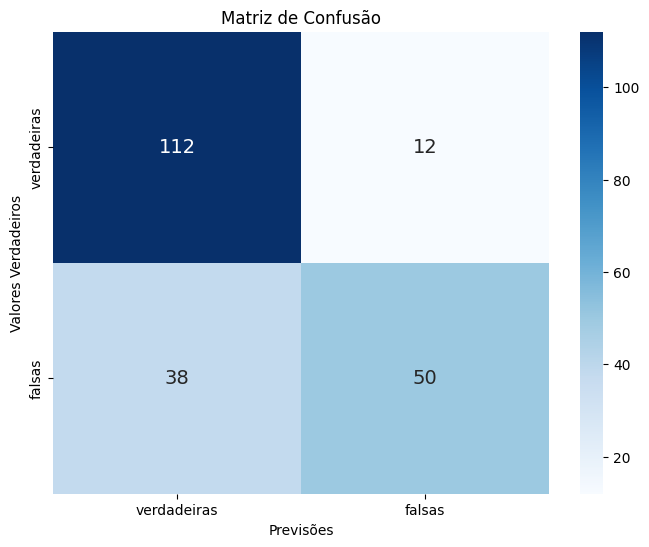

In [10]:
# Criação e visualização da matriz confusão
rotulos = ['verdadeiras', 'falsas']
cm2 = confusion_matrix(y_test, predictions2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14}, xticklabels=rotulos, yticklabels=rotulos)
plt.xlabel('Previsões')
plt.ylabel('Valores Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()